In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sn
#import functions as fn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, roc_auc_score, plot_confusion_matrix, precision_score, recall_score 

In [2]:
#View options
#'display.float_format', lambda x: '%8.0f' % x
pd.set_option('display.max_columns', None, 'display.max_rows', None)

In [3]:
#Import final polished dataframe
df = pd.read_csv('data/final.csv',encoding='cp1252')

In [4]:
df = df.drop(columns=['Unnamed: 0'], axis=1)

In [5]:
df.shape

(73040, 23)

In [6]:
#Dealing with some missing school size data before transforming
df = df[df.Total_Students.apply(lambda x: x.isnumeric())]

In [7]:
#Transform all numerical data to appropriate datatypes
df['Total_Students'] = df['Total_Students'].astype(int)

In [8]:
#Found some nonsense values in Student/Teacher ratio column, need to replace with 16 (national average)
gibberish = df.loc[df['Student_Teacher_Ratio'] == 'Ã¢â‚¬â€œ']

In [9]:
df['level'] = np.nan

In [10]:
# Enumerate to replace values in ['Level'] to simplify variables
for i, element in enumerate(df['Level']): 
    if element == 'Secondary':
        df['level'][i] = 'High'
    elif element == 'Prekindergarten': 
        df['level'][i] = 'Other'
    elif element == 'Ungraded': 
        df['level'][i] = 'Other'
    elif element == 'Not applicable':
        df['level'][i] = 'Other' 
    else: 
        df['level'][i] = element

<ipython-input-10-3d3f8f40a880>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level'][i] = element
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-10-3d3f8f40a880>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level'][i] = 'High'
<ipython-input-10-3d3f8f40a880>:10: SettingWithCopy

In [11]:
df['level'].value_counts()

Elementary    40801
High          16288
Middle        13103
Other          2608
Name: level, dtype: int64

In [12]:
df = df.drop(['Level'], axis=1)

In [13]:
df = df.rename(columns={'level':'Level'})

In [14]:
#Need to fill Nans in Level column

In [15]:
df['Student_Teacher_Ratio'].replace('Ã¢â‚¬â€œ','16',inplace=True)

In [16]:
df = df[df['Student_Teacher_Ratio'] != 'Ã¢â‚¬Â']

In [17]:
df['Student_Teacher_Ratio'].replace('Ã¢â‚¬Â\xa0','16',inplace=True)

In [18]:
df['Student_Teacher_Ratio'] = df['Student_Teacher_Ratio'].astype(float)

In [19]:
# Exploring balance of target classes
df['Target'].value_counts(normalize=True)

0    0.506308
1    0.493692
Name: Target, dtype: float64

In [20]:
#Splitting data into features and target
#Dropping all identifier columns including zipcode - as median income is based on zipcode and is a good stand-in
target = df['Target']
features = df.drop(['School_ID','School_Name','District_Name','District_ID','Zip','City','Target'], axis=1)               

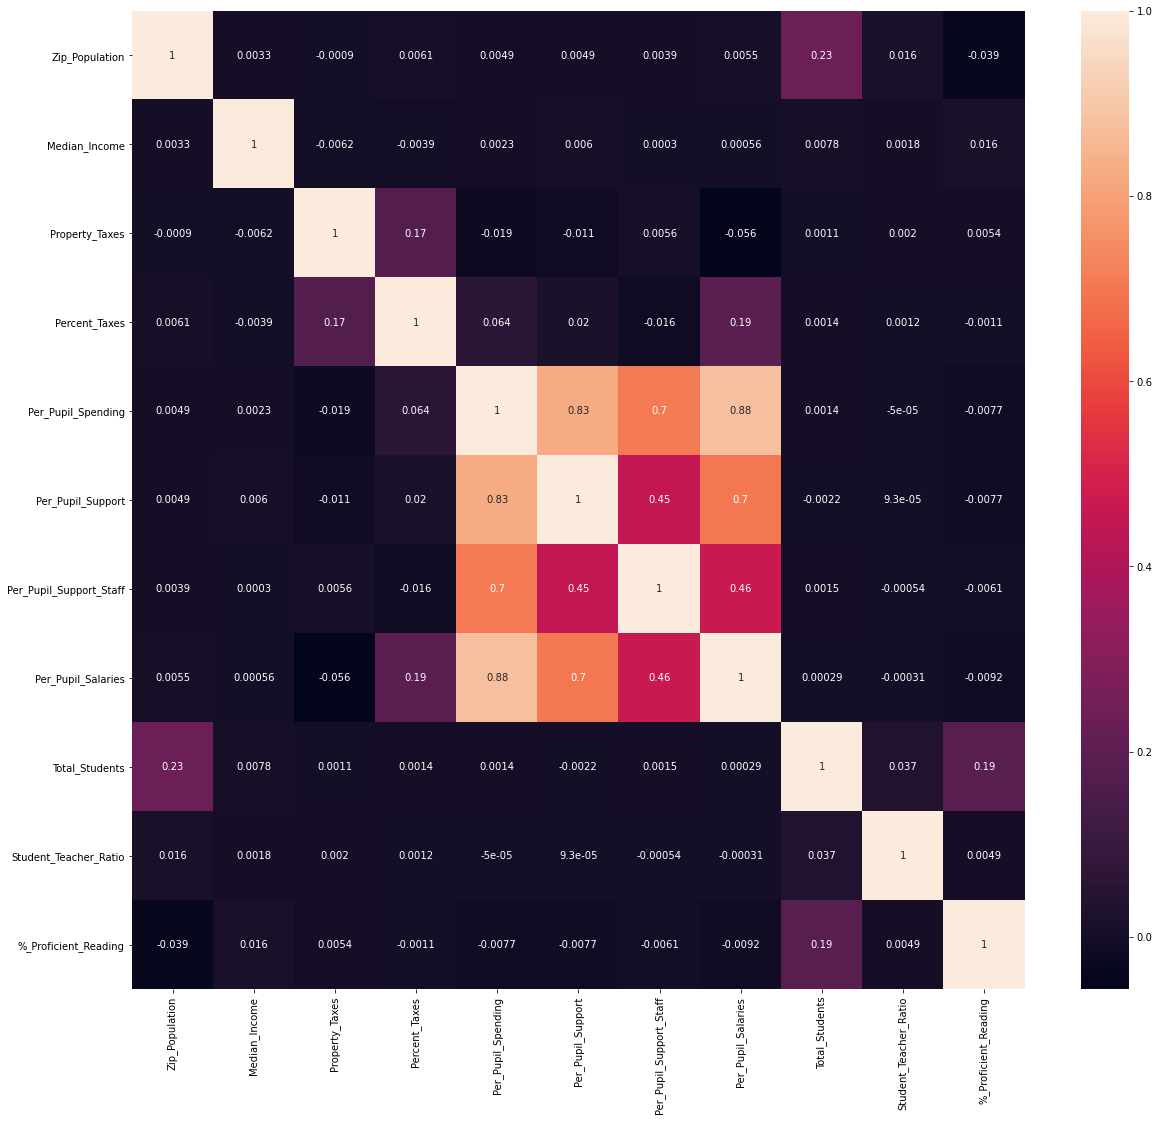

In [21]:
#Exploring multicollinearity
corr = features.corr()
pl.figure(figsize = (20,18))
sn.heatmap(corr, annot=True)
pl.show()

In [22]:
#Performing train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

### Dealing with Categorical Data

In [23]:
features.dtypes

State                       object
Zip_Population               int64
Density                     object
Median_Income                int64
Property_Taxes               int64
Percent_Taxes              float64
Per_Pupil_Spending           int64
Per_Pupil_Support            int64
Per_Pupil_Support_Staff      int64
Per_Pupil_Salaries           int64
Total_Students               int64
Student_Teacher_Ratio      float64
Title_I                     object
Virtual                     object
%_Proficient_Reading         int64
Level                       object
dtype: object

Since there are 50 state possibilities, one-hot encoding would lead to dozens of unnecessary columns. After some thought, I decided to use target encoding to deal with states, using the continuous version of the target to replace each state with the average percentage of students proficient in that state. Though this is an imperfect substitute for location, it is true that states differ markedly from each other in their levels of student achievement and tend to stay consistent from year to year (for example, Massachusetts is continually one of the top-performing states in the nation, while Louisiana is consistently one of the lowest). Thus, treating states this way should feed my model some valuable information about student performance.

In [24]:
#Target encoding state column 
#Create a groupby dataframe that gives us the mean in each numeric column for each state
state_averages = X_train.groupby(['State']).mean().reset_index()

In [25]:
state_averages = state_averages.filter(['%_Proficient_Reading','State'], axis=1).rename(columns={'%_Proficient_Reading':'State_Avg_Reading'})


In [26]:
#Join state helper dataframe with my training predictors and testing data
X_train = pd.merge(state_averages, X_train, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)
X_test = pd.merge(state_averages, X_test, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)

In [27]:
X_train.head()

,State_Avg_Reading,Zip_Population,Density,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,Title_I,Virtual,Level
0,35.559524,1410,midsize,72188,7518,35.6,10545,389,438,4049,39,4.18,yes,no,NaN
1,35.559524,1410,midsize,72188,7518,35.6,10545,389,438,4049,48,4.05,yes,no,NaN
2,35.559524,45366,midsize,61089,989357,47.9,10173,392,1145,3257,198,9.66,yes,yes,Elementary
3,35.559524,107571,urban,62602,6090,41.4,9813,581,616,3995,321,12.07,yes,yes,Elementary
4,35.559524,12114,midsize,47060,7640,36.2,13364,661,223,4595,280,15.56,yes,yes,Elementary


In [28]:
#Deal with nulls in training and testing data
X_train = X_train.fillna(value = {"Level":"Other"})
X_test = X_test.fillna(value = {'Level':'Other'})

In [29]:
#Putting X back together
X = pd.concat([X_train, X_test], axis=0)

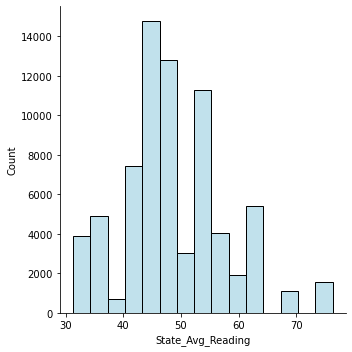

In [30]:
sn.displot(X, x='State_Avg_Reading', binwidth=3, color="lightblue")
pl.savefig("State Averages")

In [32]:
#Now need to one-hot encode  categorical columns
#Isolate categorical columns
cats = X[['Density','Title_I', 'Virtual','Level']]
#Transform data
cats = pd.get_dummies(cats)

In [33]:
cats.head()

,Density_midsize,Density_urban,Title_I_no,Title_I_yes,Virtual_no,Virtual_yes,Level_Elementary,Level_High,Level_Middle,Level_Other
0,1,0,0,1,1,0,0,0,0,1
1,1,0,0,1,1,0,0,0,0,1
2,1,0,0,1,0,1,1,0,0,0
3,0,1,0,1,0,1,1,0,0,0
4,1,0,0,1,0,1,1,0,0,0


In [36]:
#Merge with main dataframe on key values
X_numeric = pd.concat([X, cats], axis=1)

In [38]:
#Drop non-numeric categorical columns 
X_numeric = X.drop(['Density','Title_I', 'Virtual','Level'], axis=1)

In [40]:
#Have to re-do the train test split
X_train, X_test, y_train, y_test = train_test_split(X_numeric, target, test_size=0.20, random_state=42)

### Scaling Data